## Pokemon 3: Return of the Kingler

#### Hayden Burger, Corinne Desroches, David Lee

(Tutorial requirements):

Accurately summarizes original presentation and incorporates feedback.  Effectively presents entire data analysis workflow in written form, with appropriate references.  Serves as tutorial to enable other users to understand and repeat analysis. 

Makes effective use of the GitLab platform to organize code, provide data downloading instructions, ensuring project can be replicated by other users, and includes overall aesthetics of Readme document. 


To do:

[/] Brief intro

[] Discuss API

[x] Discuss python scripts

[x] Discuss running script/ Hamming/ shell command

[x] Discuss data format

[] Discuss data imaging/ streamlit

### Introduction

Pokémon, as a franchise, is a battle and adventure simulator where a player can catch, train, and battle with creatures called pokémon. Each pokémon has a type, speed, attack, defense, moveset, and a number of other stats that determine its strengths and weaknesses in battle. Every 'generation' of Pokémon games introduces new pokémon, moves, and mechanics that increase the complexity of the game. For this project we retained just the first 151 Pokémon from the first generation, corresponding to the video games of Pokémon Red, Blue, and Yellow. We also are using the Elite Four from those games as our metric for an effective team of pokémon. These elite trainers are used in the game as a type of final boss, and are billed as the strongest trainers in the game.

On previous iterations of this project, we have built up from a 1v1 simulation of each attack and defense, all the way to teams of 6 pokémon battling against sequential enemy teams. We have remained as faithful to the game as possible, using the in-game battle equations and stats. We have also used the in-game type advantages and disadvantages to determine the effectiveness of each attack. We did not use move limits (PP), modified traits (IV or EV), items, or switching pokémon in battle. We have used all the status conditions that were applicable in this generation (sleep, confusion, poison, dig, etc).


### Data Gathering

### Running Random Team Battles

#### Creating Teams

In order to run multiple Pokemon teams against the Elite Four, we first need to select which Pokemon make up a team. We chose to create random teams, using `np.random.choice` to select 6 from the Generation 1 Pokemon. The function `random_team_names` below samples with replacement, meaning it's possible to have multiple of the same type of Pokemon, just like in the games. It calls from pokemon_dict, which is a dictionary referencing each Pokemon class by their name. It's a function of `pokemon_module` and it can be called via `pokemon_dict = pk.create_pokemon_dict()`.

```python
def random_team_names(n):
    '''Generates n pokemon names'''
    team = []
    for i in range(n):
        pokemon_name = np.random.choice(list(pokemon_dict.keys()))
        team.append(pokemon_name)
    return team

def save_teams(n,filename):
    '''writes n random teams to CSV file'''
    with open(filename,'w',newline='') as file:
        writer = csv.writer(file)
        for i in range(n):
            team = random_team_names(6) 
            writer.writerow(team)
    return 
```      
The `save_teams` function will call the other function to create teams of six, and write each to a line in a CSV. For early iterations, we just called `save_teams` with a filename to create a file of n teams. However, for very large numbers, the process is slow, and the CSV is potentially unviable. (Programs that open CSVs have row limits, and most software is limited to about 1 million lines.)

So the next step was to create a way to split this process up. The python script `create_teams.py` contains the functions above, and calls as an argument a CSV index. It will create a CSV of 100,000 teams, named with that index using the `fstring` functionality of python:

```python
filename = f'Input_data_files/random_teams_{csv_index}.csv'
```
In order to access the input, it calls the module `sys`. Each argument when called from a command line (or batch script) becomes part of the variable sys.argv. The handling in `create_teams.py` will take the input if it exists, and otherwise will use a default team and set the index to 0. This was run in the NPS High Performance Computing System, Hamming, using slurm commands. 


#### Hamming and Slurm

If you have a Hamming account, Hamming can be accessed from a terminal with the command `FIND COMMAND`. The terminal MobaXterm was used, as it has a simple GUI that allows easy uploading and downloading of files.

On Hamming, we used a virtual environment for consistent access to the required python modules. This environment can be created via the command `python -m venv {environment path}`. Specifically, we used an environment `comp3`, created for the class and located in the smallwork part of Hamming. The environment was activated using `source /smallwork/$USER/comp3/bin/activate`.

The required modules to have installed are pandas and numpy. After loading python via `load lang/python`, these can be pip installed, e.g. `python -m pip install pandas`. 

After we have the virtual environment, we can run batch scripts that access it. The script used to create teams, calling `create_teams.py`, is below.

```bash
#!/bin/sh

#SBATCH --job-name create_random_csv
#SBATCH --array=0-99
#SBATCH --output=Output_data_files/out_input.txt

. /etc/profile
module load lang/python
## load the comp3 virtual environment
source /smallwork/$USER/comp3/bin/activate

## arguments:  team number, number of runs
python create_teams.py ${SLURM_ARRAY_TASK_ID}
```

The top line indicates that it is a bash script. The `#SBATCH` lines are commands for how to execute the script. The first defines the job name, the second runs the script 100 times, and the last directs the output from the command line to a txt file. The python script is called with `${SLURM_ARRAY_TASK_ID}` as an argument, which will be one of the numbers from 0 to 99. This will create 100 CSVs of 100,000 lines each, each line a team of six random pokemon.

The batch file is run from the command line of the terminal. First, `salloc` is called to allocate computing resources for the task. Then the script is run with `sbatch create_input.sh`.

#### Running the Scenario

The script `pokemon_script.py` imports `pokemon_module.py` as `pk` in order to utilize its functions. It takes as input a team index number and the number of battles to run for each team. If the input isn't provided, both are defaulted to one.

```python
#Arguments: poke_index, n_fights
if len(sys.argv) >=2:
    poke_index = int(sys.argv[1])
    n_fights = int(sys.argv[2])
else:
    #Not enough inputs
    poke_index = 1
    n_fights = 1
```

The script will load the team from the CSV, based on the index. `math.floor` is used to identify which CSV to load to find the team name. For teams 1-100,000, the random_teams_0.csv contains the appropriate team, and so on. The appropriate CSV is saved as a dataframe. The modulus operator `%` is used to find which row in the dataframe corresponds to the team. For example, team 100002 is the second team of its CSV and corresponding dataframe.

```python
#Load player team from CSV
team_index = math.floor((poke_index-1)/100000)
infilename = "Input_data_files/random_teams_{team_index}.csv"
teams = pd.read_csv(infilename,header=None)
csv_loc = (poke_index%100000)-1
player_team = teams.loc[csv_loc].to_list()
```

The Pokemon names of the team are saved to a list.

After that the script defines lists for each of the elite four teams. We then use the pokemon_module function `create_pokemon_objects` to create pokemon classes for each team. This turns a list of pokemon names into a dictionary of pokemon class objects, indexed by their name. This can be called with `pk.create_pokemon_objects({pokemon list})`. The player team and each team in the elite four is converted to a dictionary, and the elite four dictionaries are saved in a list called `elite`.

The battle is then run using the code below, again referencing a pokemon_module function. `run_elite` will run pokemon battles for every member of the player team against every member of an opponent team, for each of the opponent teams. It is designed to take a list of exactly four teams for the elite four, and will print an error for a different team construction. This `run_elite` function is run inside a locally defined function called sim_elite, which produces a dataframe for all the runs of the player team against the elite four.

```python
#function to run num_runs battles and save results to dataframe
def sim_elite(team,elite,num_runs=10):
    results = pd.DataFrame(columns=['Result','Time','Winner','Winner List'])
    for i in range(num_runs):
        result,time,teamname,winnerlist = pk.run_elite(team,elite,verbose=False,roundreset=False)
        results.loc[i] = [result,time,teamname,winnerlist]
    return results
```

Results are saved in the form of (Result, Time, Winner, Winner List). The `Result` is a 1 or 0 for whether the player team wins or loses, respectively. `Time` is the amount of time the battle takes, assuming each round is six seconds. `Winner` returns the winning team, whether that is the player ("Champion") or a member of the Elite Four. `Winner List` is a list of battle outcomes in order, so for every 1v1 pairing it will have either the name of the winning pokemon or "Draw". 

After running the designated number of battles, `pokemon_script.py` will aggregate the results to a single line containing: a list of team members, the "efficiency" (number of wins/average time), number of wins, average win time, standard deviation of the win time, average lose time, standard deviation of the lose time, number of losses to each Elite Four team (Lorelei, Bruno, Agatha, and Lance), the "nemesis", which is the pokemon that the team lost to most consistently, and the number of times that team lost to that nemesis.

The results are written to an csv using the pandas ability `.to_csv`. By aggregating the data of multiple battles before saving it, each resulting csv consists of a single line to save storage.

```python
file_name = f"./Output_data_files/results_team_{poke_index}.csv"
collectedresults_df.to_csv(file_name)
```

`pokemon_script.py` is run with the batch script `pokemon_battle.sh`. The script creates a job named `HEB_pokemonbattle`, divided into `100,000` tasks, and sends any output to `out_battle.txt`. It loads python, and activates the comp3 virtual environment that was created on Hamming in this course. 

```bash
#!/bin/sh

#SBATCH --job-name HEB_pokemonbattle
#SBATCH --array=0-99999
#SBATCH --output=Output_data_files/out_battle.txt

. /etc/profile
module load lang/python
## load the comp3 virtual environment
source /smallwork/$USER/comp3/bin/activate

python pokemon_battle.py ${SLURM_ARRAY_TASK_ID} 100
```

Note: the slurm array value cannot go to 6 digits. The highest value is 99,999. Thus, while the intent was to run 10 million teams, it was only possible to do 100,000 in a single command.

#### Collecting Results

The code above will produce 100,000 CSVs of a single line each, named `results_team_{poke_index}`. They need to be collected into a single CSV. `Combine_output.py` will take a CSV index as input, much like the create_teams script. The index will dictate which results to read to a dataframe, and will write to a CSV with the index name. With csv_index =0, the code will save all team results from 0 to 99,999 to a file Team_Summary_0.csv. If you were to have 10 million teams, you would produce 100 of these files, matching the number of input CSVs.

The code relies on the `glob` module to search the output folder for all the filenames that follow the format. For each one, the team number is retrieved and divided by 100,000 to identify which chunk of data it belongs to. If that matches the `csv_index`, the file is loaded to a dataframe and appended, again using the pandas `to_csv` method.

```python
paths = glob.glob("./Output_data_files/results_team_*.csv")
```

The code is from a batch file, called with `sbatch combine_output.sh`. Structurally, it mirrors `create_input.sh`.

```bash
#!/bin/sh

#SBATCH --job-name summarize_pokemon
#SBATCH --array=0-99
#SBATCH --output=Output_data_files/out_summarize.txt

. /etc/profile
module load lang/python
## load the comp3 virtual environment
source /smallwork/$USER/comp3/bin/activate

## arguments:  team number, number of runs
python Combine_output.py ${SLURM_ARRAY_TASK_ID}
```

### Data Presentation

 Gengar is the common thread of every team with a win percentage of 60% or more against the Elite Four.
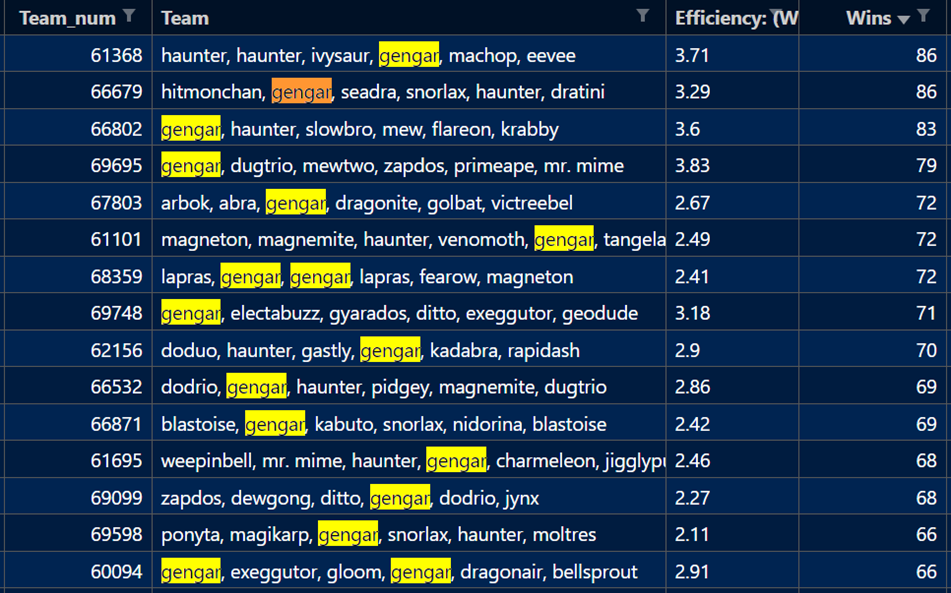

